# Neural Networks for Collaborative Filtering
> Neural networks to learn the embeddings! and how to combine them

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

Recently, I had a chance to read an interesting WWW 2017 paper entitled: [Neural Collaborative Filtering](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf). The first paragraph of the abstract reads as follows:

>In recent years, deep neural networks have yielded immense success on speech recognition, computer vision and natural language processing. However, the exploration of deep neural networks on recommender systems has received relatively less scrutiny. In this work, we strive to develop techniques based on neural networks to tackle the key problem in recommendation — collaborative filtering — on the basis of implicit feedback.

I'd recently written a [blog post](../recommend-keras.html) on using Keras (deep learning library) for implementing traditional matrix factorization based collaborative filtering. So, I thought to get my hands dirty with building a prototype for the paper mentioned above. The authors have already provided their [code on Github](https://github.com/hexiangnan/neural_collaborative_filtering), which should serve as a reference for the paper and not my post, whose purpose is merely educational!


Here's how the proposed network architecture looks in the paper:

![](https://nipunbatra.github.io/blog/images/neumf.png)

There are a few terms that we need to understand:
    
1. User (u) and Item (i) are used to create embeddings (low-dimensional) for user and item
2. Generalized Matrix Factorisation (GMF) combines the two embeddings using the dot product. This is our regular matrix factorisation.
3. Multi-layer perceptron can also create embeddings for user and items. However, instead of taking a dot product of these to obtain the rating, we can concatenate them to create a feature vector which can be passed on to the further layers.
4. Neural MF can then combine the predictions from MLP and GMF to obtain the following prediction.

As done in my previous post, I'll use the MovieLens-100k dataset for illustration. Please refer to my [previous post](../recommend-keras.html) for more details.

### Peak into the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
dataset = pd.read_csv("/Users/nipun/Downloads/ml-100k/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))

In [3]:
dataset.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


So, each record (row) shows the rating for a user, item (movie) pair. It should be noted that I use  item and movie interchangeably in this post.

In [4]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

We assign a unique number between (0, #users) to each user and do the same for movies.

In [5]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [6]:
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,3,881250949
1,185,301,3,891717742
2,21,376,1,878887116
3,243,50,2,880606923
4,165,345,1,886397596


### Train test split

We'll now split our dataset of 100k ratings into train (containing 80k ratings) and test (containing 20k ratings). Given the train set, we'd like to accurately estimate the ratings in the test set.

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2)

In [8]:
train.head()

,user_id,item_id,rating,timestamp
13185,71,95,5,880037203
23391,144,509,4,882181859
90744,895,50,2,887159951
3043,255,279,5,882151167
8932,55,94,4,892683274


In [9]:
test.head()
y_true = test.rating

### Creating the model

In [10]:
import keras
n_latent_factors_user = 8
n_latent_factors_movie = 10
n_latent_factors_mf = 3
n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)


concat = keras.layers.merge([movie_vec_mlp, user_vec_mlp], mode='concat',name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

pred_mf = keras.layers.merge([movie_vec_mf, user_vec_mf], mode='dot',name='Dot')


pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

combine_mlp_mf = keras.layers.merge([pred_mf, pred_mlp], mode='concat',name='Concat-MF-MLP')
result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


result = keras.layers.Dense(1,name='Prediction')(deep_combine)


model = keras.Model([user_input, movie_input], result)
opt = keras.optimizers.Adam(lr =0.01)
model.compile(optimizer='adam',loss= 'mean_absolute_error')

Using TensorFlow backend.


Let's now see how our model looks like:

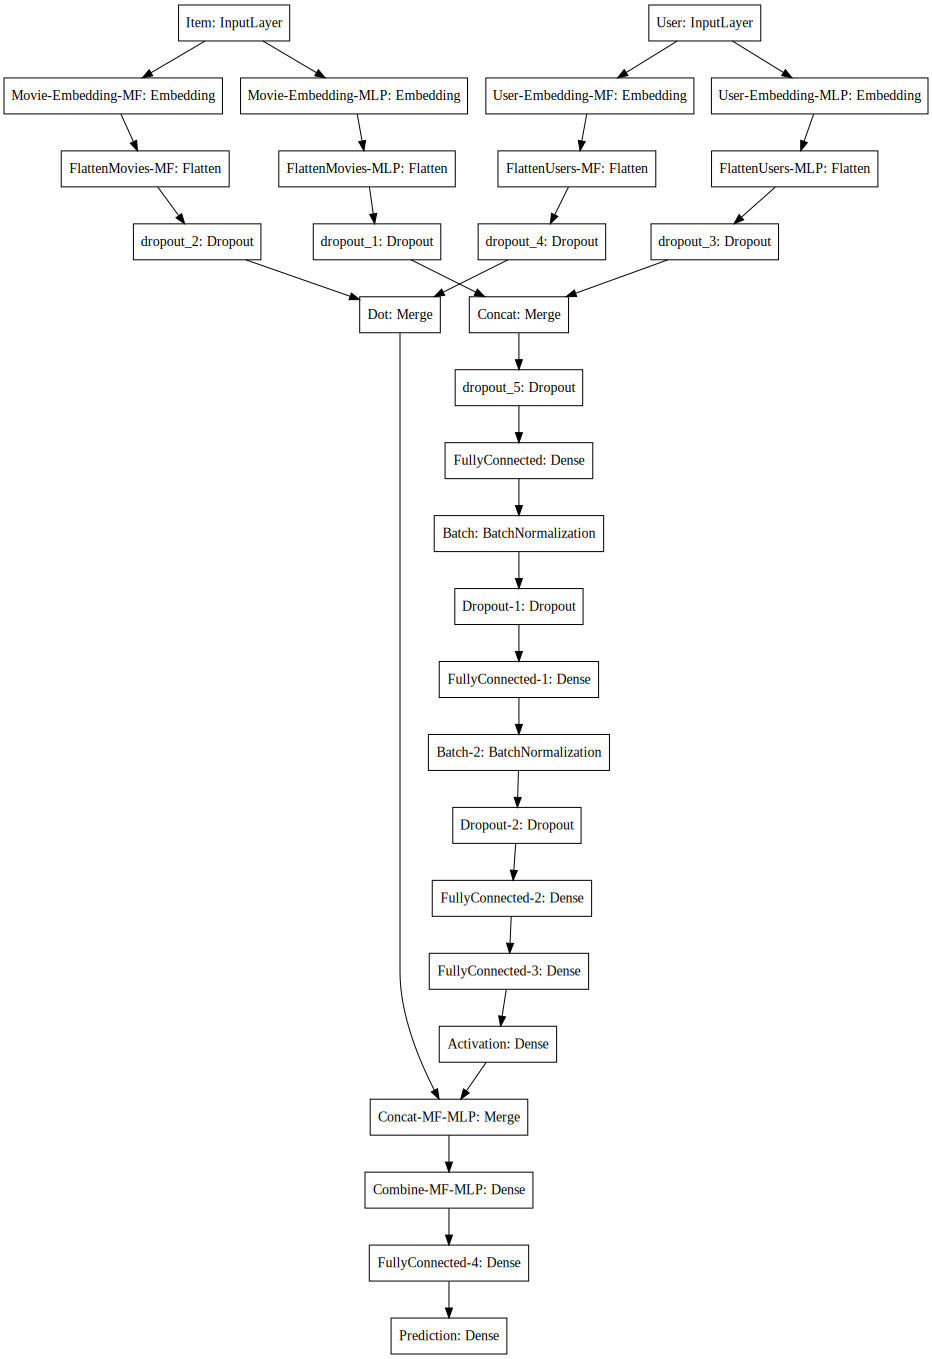

In [11]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

So, it wasn't very complicated to set up. Courtesy Keras, we can do even more complex stuff!

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding-MLP (Embedding) (None, 1, 10)        16830       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding-MLP (Embedding)  (None, 1, 8)         7552        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

We can see that the number of parameters is more than what we had in the Matrix Factorisation case. Let's see how this model works. I'll run it for more epochs given that we have more parameters.

In [13]:
history = model.fit([train.user_id, train.item_id], train.rating, epochs=25, verbose=0, validation_split=0.1)

### Prediction performance of Neural Network based recommender system

In [14]:
from sklearn.metrics import mean_absolute_error
y_hat_2 = np.round(model.predict([test.user_id, test.item_id]),0)
print(mean_absolute_error(y_true, y_hat_2))

print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))




0.716
0.737380115688


Pretty similar to the result we got using matrix factorisation. This isn't very optimised, and I am sure doing so, we can make this approach perform much better than GMF!

Thanks for reading. This post has been a good learning experience for me. Hope you enjoyed too! 